In [1]:
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [2]:
DIRECTORY = 'images'

files = os.listdir(DIRECTORY)

In [3]:
TRAIN_SIZE = 100
BATCH_SIZE = 5
OUTPUT_SIZE = 50

OUTPUT_SIZE -= OUTPUT_SIZE%4

x_train=[]

for i in range(0, TRAIN_SIZE):
    added=[]
    img = Image.open(DIRECTORY+'\\'+files[i])
    img=img.resize((OUTPUT_SIZE, OUTPUT_SIZE))
    for i0 in range(OUTPUT_SIZE):
        for i1 in range(OUTPUT_SIZE):
            added.append(img.getpixel((i1,i0)))
    x_train.append([added])

x_train=np.array(x_train)
x_train = x_train / 255
x_train = np.reshape(x_train, (len(x_train), OUTPUT_SIZE, OUTPUT_SIZE, 3))

BUFFER_SIZE = x_train.shape[0]
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE

x_train = x_train[:BUFFER_SIZE]


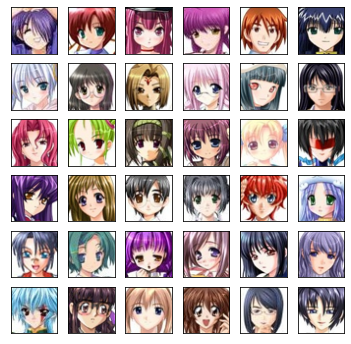

In [4]:
SIZE = 6

plt.figure(figsize=(SIZE, SIZE))
num=1
for i in range(0, SIZE):
    for j in range(0, SIZE):
        ax = plt.subplot(SIZE, SIZE, num)
        plt.imshow(x_train[num-1, :, :, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        num += 1
plt.show()

In [5]:
INPUT_DIM = 5

generator = tf.keras.Sequential([
    Dense((OUTPUT_SIZE//4) * (OUTPUT_SIZE//4) * 256, activation='relu', input_shape=(INPUT_DIM,)),
    BatchNormalization(),
    Reshape((OUTPUT_SIZE//4, OUTPUT_SIZE//4, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])
#print(generator.summary())


discriminator = tf.keras.Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[OUTPUT_SIZE, OUTPUT_SIZE, 3]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Flatten(),
    Dense(1),
])
#print(discriminator.summary())

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, INPUT_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

    for epoch in range(1, epochs + 1):
        
        is_print=((epoch-2) % PRINT_STEP == 0)
        if is_print:
            print(f'{epoch}/{EPOCHS}: ', end='')

        start = time.time()
        n = 0
        
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0 and is_print): print('=', end='')
            n += 1
            
        history += [gen_loss_epoch / n]
        if is_print:
            print(': ' + str(history[-1]))
            print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))
            print('Примерное оставшееся время: {} секунд'.format(int((time.time() - start)*(epochs - epoch))))
            print('')

    return history

In [9]:
EPOCHS = 1000
PRINT_STEP = 100

history = train(train_dataset, EPOCHS)

2/1000: ==========: tf.Tensor(1.1441804, shape=(), dtype=float32)
Время эпохи 2 составляет 2.050356149673462 секунд
Примерное оставшееся время: 2046 секунд

102/1000: ==========: tf.Tensor(1.1890002, shape=(), dtype=float32)
Время эпохи 102 составляет 1.6458404064178467 секунд
Примерное оставшееся время: 1477 секунд

202/1000: ==========: tf.Tensor(1.3837821, shape=(), dtype=float32)
Время эпохи 202 составляет 1.7165145874023438 секунд
Примерное оставшееся время: 1369 секунд

302/1000: ==========: tf.Tensor(1.325364, shape=(), dtype=float32)
Время эпохи 302 составляет 2.4365947246551514 секунд
Примерное оставшееся время: 1700 секунд

402/1000: ==========: tf.Tensor(1.3580039, shape=(), dtype=float32)
Время эпохи 402 составляет 1.9086945056915283 секунд
Примерное оставшееся время: 1141 секунд

502/1000: ==========: tf.Tensor(1.4019774, shape=(), dtype=float32)
Время эпохи 502 составляет 1.7693257331848145 секунд
Примерное оставшееся время: 881 секунд

602/1000: ==========: tf.Tensor(1.5

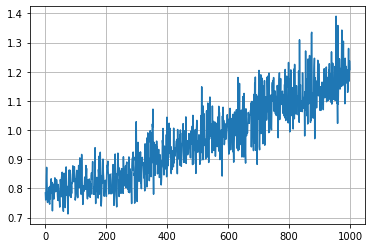

In [10]:
plt.plot(history)
plt.grid(True)
plt.show()

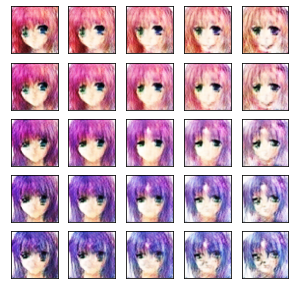

In [10]:
SIZE = 5
n = SIZE // 2

plt.figure(figsize=(SIZE, SIZE))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(SIZE, SIZE, num)
        key=np.resize([0.5 * i / n, 0.5 * j / n],(1, INPUT_DIM))
        img = generator.predict(key)
        plt.imshow(img[0, :, :, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        num += 1

plt.show()

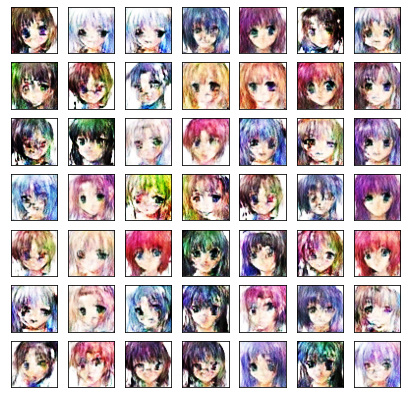

In [11]:
SIZE = 7

plt.figure(figsize=(SIZE, SIZE))

num = 1
for i in range(0 ,SIZE):
    for j in range(0, SIZE):
        ax = plt.subplot(SIZE, SIZE, num)
        img = generator.predict(tf.random.normal([1, INPUT_DIM]))
        plt.imshow(img[0, :, :, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        num += 1

plt.show()

In [12]:
generator.save("generator")
discriminator.save("discriminator")

INFO:tensorflow:Assets written to: generator\assets
INFO:tensorflow:Assets written to: discriminator\assets


In [7]:
generator = tf.keras.models.load_model("generator")
discriminator = tf.keras.models.load_model("discriminator")